In [5]:
# Core Libraries
import pandas as pd
import torch
import duckdb
from rdkit import Chem
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import duckdb


In [2]:
# Paths to datasets
train_path = "train.parquet"
test_path = "test.parquet"

# Set target dataset size
target_size = 500_000  # Final number of rows
positive_ratio = 1 / 6  # 5:1 ratio (1 positive per 5 negatives)

# **Step 1: Sample a Portion of Positive (binds=1) Samples**
print("🔹 Sampling positive binding molecules...")
pos_query = f"SELECT * FROM '{train_path}' WHERE binds = 1 ORDER BY RANDOM() LIMIT {int(target_size * positive_ratio)}"
pos_df = duckdb.query(pos_query).to_df()

# Count sampled positives
num_positives = len(pos_df)
num_negatives_needed = target_size - num_positives  # Adjust negatives to match total target size

print(f"✅ Sampled {num_positives} positive samples. Need {num_negatives_needed} negatives.")

# **Step 2: Randomly Sample Negative (binds=0) Samples**
neg_query = f"""
    SELECT * FROM (
        SELECT * FROM '{train_path}' WHERE binds = 0 
        ORDER BY RANDOM() 
        LIMIT {num_negatives_needed}
    )
"""
neg_df = duckdb.query(neg_query).to_df()

# **Step 3: Merge & Shuffle the Final Balanced Dataset**
train_df = pd.concat([pos_df, neg_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# **Step 4: Load the Full Test Set**
test_df = duckdb.query(f"SELECT * FROM '{test_path}'").to_df()

# **Final Checks**
print(f"\n✅ Final Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")
print("\n🔹 Bind Label Distribution in Train:")
print(train_df["binds"].value_counts(normalize=True))



🔹 Sampling positive binding molecules...
✅ Sampled 83333 positive samples. Need 416667 negatives.

✅ Final Train Shape: (500000, 7), Test Shape: (1674896, 6)

🔹 Bind Label Distribution in Train:
binds
0    0.833334
1    0.166666
Name: proportion, dtype: float64


/home/codingnewt/miniconda3/envs/CGNN/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


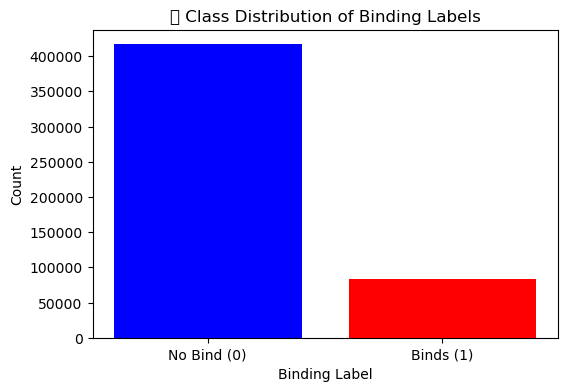

In [6]:
import matplotlib.pyplot as plt

# Bar plot of bind distribution
bind_counts = train_df["binds"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(["No Bind (0)", "Binds (1)"], bind_counts, color=["blue", "red"])
plt.xlabel("Binding Label")
plt.ylabel("Count")
plt.title("🔹 Class Distribution of Binding Labels")
plt.show()


/tmp/ipykernel_73859/932357589.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_df["protein_name"], order=["BRD4", "HSA", "sEH"], palette="muted")
/home/codingnewt/miniconda3/envs/CGNN/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


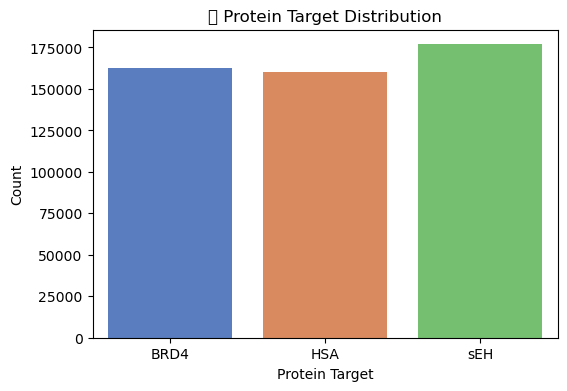

In [7]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=train_df["protein_name"], order=["BRD4", "HSA", "sEH"], palette="muted")
plt.xlabel("Protein Target")
plt.ylabel("Count")
plt.title("🔹 Protein Target Distribution")
plt.show()


In [8]:
from rdkit.Chem import Descriptors

# Compute molecular weight for each molecule
train_df["mol_weight"] = train_df["molecule_smiles"].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)) if Chem.MolFromSmiles(x) else None)

# Plot distribution
plt.figure(figsize=(7,5))
sns.histplot(train_df["mol_weight"], bins=50, kde=True, color="purple")
plt.xlabel("Molecular Weight")
plt.ylabel("Density")
plt.title("🔹 Molecular Weight Distribution")
plt.show()


KeyboardInterrupt: 

In [9]:
import torch
from torch_geometric.data import Data
from tqdm import tqdm
from rdkit import Chem


In [10]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")


🚀 Using device: cuda


In [11]:
def mol_to_graph(smiles):
    """
    Converts a SMILES string into a PyTorch Geometric graph.
    
    Args:
        smiles (str): SMILES representation of the molecule.
    
    Returns:
        torch_geometric.data.Data: Graph representation of the molecule.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Skip invalid molecules

    # **Generate Node Features**
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append([
            atom.GetAtomicNum(),  # Atomic number
            atom.GetTotalDegree(),  # Number of bonds
            atom.GetTotalValence(),  # Valence electrons
            atom.GetIsAromatic()  # Aromatic flag
        ])
    
    # **Generate Edges & Edge Features**
    edge_index = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])  # Undirected graph

        # Bond features: Bond type as one-hot
        edge_features.append([bond.GetBondTypeAsDouble()])
        edge_features.append([bond.GetBondTypeAsDouble()])  # Add reverse direction

    # Convert lists to tensors & move to GPU
    x = torch.tensor(node_features, dtype=torch.float).to(device)
    edge_index = torch.tensor(edge_index, dtype=torch.long).T.to(device)
    edge_attr = torch.tensor(edge_features, dtype=torch.float).to(device)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# **Apply GPU-Accelerated Graph Conversion**
graph_data_list = []
for i, row in tqdm(train_df.iterrows(), total=len(train_df), desc="🔄 Converting SMILES to Graphs (GPU)"):
    graph = mol_to_graph(row["molecule_smiles"])
    if graph:
        # One-hot encode protein target
        graph.protein_features = torch.tensor([1 if row["protein_name"] == p else 0 for p in ["BRD4", "HSA", "sEH"]], dtype=torch.float).to(device)
        graph.y = torch.tensor([row["binds"]], dtype=torch.float).to(device)
        graph_data_list.append(graph)

print(f"✅ Converted {len(graph_data_list)} molecules into graphs.")


🔄 Converting SMILES to Graphs (GPU):   1%|          | 3005/500000 [00:02<07:52, 1051.38it/s]


KeyboardInterrupt: 

In [20]:
# Save processed graph data
torch.save(graph_data_list, "graph_data.pt")
print("✅ Graph representations saved to 'graph_data.pt'")


✅ Graph representations saved to 'graph_data.pt'


### LOADING MOLECULE GRAPHS IF NEEDED

In [12]:
# Load saved graph data
graph_data_list = torch.load("graph_data.pt", map_location=device)
print(f"✅ Loaded {len(graph_data_list)} graphs from disk.")


✅ Loaded 500000 graphs from disk.


In [13]:
# Pick a random sample from our processed graphs
import random
sample_graph = random.choice(graph_data_list)

# Print graph details
print("\n🔹 **Checking a Sample Graph Representation:**")
print(f"- Number of Nodes (Atoms): {sample_graph.x.shape[0]}")
print(f"- Node Features Shape: {sample_graph.x.shape}")  # Should be [num_atoms, feature_dim]
print(f"- Edge Index Shape: {sample_graph.edge_index.shape}")  # Should be [2, num_edges]
print(f"- Edge Features Shape: {sample_graph.edge_attr.shape}")  # Should be [num_edges, feature_dim]
print(f"- Protein Features Shape: {sample_graph.protein_features.shape}")  # Should be [3]
print(f"- Label (y): {sample_graph.y.item()}")  # Should be 0 or 1



🔹 **Checking a Sample Graph Representation:**
- Number of Nodes (Atoms): 37
- Node Features Shape: torch.Size([37, 4])
- Edge Index Shape: torch.Size([2, 80])
- Edge Features Shape: torch.Size([80, 1])
- Protein Features Shape: torch.Size([3])
- Label (y): 0.0


In [14]:
from torch_geometric.loader import DataLoader

# Define batch size
batch_size = 64  # Adjust based on available GPU memory

# Create DataLoader
train_loader = DataLoader(graph_data_list, batch_size=batch_size, shuffle=True)

print(f"✅ DataLoader initialized with {len(train_loader)} batches.")


✅ DataLoader initialized with 7813 batches.


In [15]:
# Check DataLoader output
batch = next(iter(train_loader))

print("\n🔹 **Checking Batch Structure:**")
print(f"- Batched Node Features Shape: {batch.x.shape}")  # Should be [total_atoms, 4]
print(f"- Batched Edge Index Shape: {batch.edge_index.shape}")  # Should be [2, total_edges]
print(f"- Batched Edge Features Shape: {batch.edge_attr.shape}")  # Should be [total_edges, 1]
print(f"- Batched Protein Features Shape: {batch.protein_features.shape}")  # Should be [batch_size, 3]
print(f"- Batched Labels Shape: {batch.y.shape}")  # Should be [batch_size]



🔹 **Checking Batch Structure:**
- Batched Node Features Shape: torch.Size([2644, 4])
- Batched Edge Index Shape: torch.Size([2, 5758])
- Batched Edge Features Shape: torch.Size([5758, 1])
- Batched Protein Features Shape: torch.Size([192])
- Batched Labels Shape: torch.Size([64])


In [16]:
# Fetch a batch
batch = next(iter(train_loader))

# ✅ Reshape protein_features dynamically
batch.protein_features = batch.protein_features.view(batch.y.shape[0], 3)  # Ensure [batch_size, 3]

# Print to verify
print("\n🔹 **Checking Fixed Batch Structure (Without Reprocessing):**")
print(f"- Batched Node Features Shape: {batch.x.shape}")  
print(f"- Batched Edge Index Shape: {batch.edge_index.shape}")  
print(f"- Batched Edge Features Shape: {batch.edge_attr.shape}")  
print(f"- Batched Protein Features Shape (Fixed): {batch.protein_features.shape}")  # ✅ Should now be [batch_size, 3]
print(f"- Batched Labels Shape: {batch.y.shape}")  



🔹 **Checking Fixed Batch Structure (Without Reprocessing):**
- Batched Node Features Shape: torch.Size([2611, 4])
- Batched Edge Index Shape: torch.Size([2, 5668])
- Batched Edge Features Shape: torch.Size([5668, 1])
- Batched Protein Features Shape (Fixed): torch.Size([64, 3])
- Batched Labels Shape: torch.Size([64])


In [17]:
# Print first few protein feature rows to verify correctness
print("\n🔹 **Checking First 5 Protein Features (Should be One-Hot Encoded):**")
print(batch.protein_features[:5])  # Should contain only 1s and 0s



🔹 **Checking First 5 Protein Features (Should be One-Hot Encoded):**
tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]], device='cuda:0')


In [18]:
# Count occurrences of each protein type
protein_counts = batch.protein_features.sum(dim=0).cpu().numpy()

# Print counts for each protein
print(f"\n🔹 Protein Distribution in Batch:")
print(f"- BRD4: {int(protein_counts[0])} molecules")
print(f"- HSA: {int(protein_counts[1])} molecules")
print(f"- sEH: {int(protein_counts[2])} molecules")



🔹 Protein Distribution in Batch:
- BRD4: 21 molecules
- HSA: 16 molecules
- sEH: 27 molecules


### Building The Model


In [32]:
import time
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def train_gnn(
    graph_data_list,
    model_type="GAT",
    epochs=10,
    batch_size=64,
    lr=5e-4,
    weight_decay=1e-5,
    checkpoint_path="gat_model_checkpoint.pt",
    clear_memory=True
):
    if clear_memory:
        torch.cuda.empty_cache()
        print("🧹 Cleared CUDA memory before training!")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Using device: {device}")

    train_graphs, val_graphs = train_test_split(graph_data_list, test_size=0.2, random_state=42)
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False, num_workers=0)

    class BindingPredictor(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = GATConv(4, 64, heads=4, concat=True)  # [*, 256]
            self.bn1 = BatchNorm1d(256)
            self.conv2 = GATConv(256, 64, heads=4, concat=True)  # [*, 256]
            self.bn2 = BatchNorm1d(256)
            self.conv3 = GATConv(256, 64, heads=1, concat=False)  # [*, 64]
            self.bn3 = BatchNorm1d(64)
            self.dropout = Dropout(0.2)
            self.protein_fc = Linear(3, 64)
            self.hidden_fc = Linear(128, 64)
            self.final_fc = Linear(64, 1)

        def forward(self, data):
            x = self.bn1(F.elu(self.conv1(data.x, data.edge_index)))
            x = self.dropout(x)
            x = self.bn2(F.elu(self.conv2(x, data.edge_index)))
            x = self.dropout(x)
            x = self.bn3(F.elu(self.conv3(x, data.edge_index)))
            x = global_mean_pool(x, data.batch)
            protein_emb = F.elu(self.protein_fc(data.protein_features))
            combined = torch.cat([x, protein_emb], dim=1)
            combined = F.elu(self.hidden_fc(combined))
            combined = self.dropout(combined)
            return self.final_fc(combined)

    model = BindingPredictor().to(device)
    pos_weight = torch.tensor([2.0], device=device)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    print(f"\n📊 Training a {model_type} Model for {epochs} epochs...\n")
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []
        start_time = time.time()

        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch).view(-1, 1)
            loss = loss_fn(output, batch.y.view(-1, 1).float())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs  # Total loss as sum

            probs = torch.sigmoid(output).detach().cpu()
            preds = (probs > 0.5).long().view(-1)
            labels = batch.y.view(-1).long().cpu()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

            if batch_idx == 0:
                print(f"🔍 Batch 0 - Loss: {loss.item():.4f}, Preds: {preds[:5].tolist()}, Labels: {labels[:5].tolist()}")

        # Total loss (sum over all samples)
        train_loss_total = total_loss
        # Avg loss per sample
        train_loss_avg = total_loss / len(train_graphs)
        # "Scaled" loss (adjusted for pos_weight=2.0 to balanced equivalent)
        train_loss_scaled = train_loss_avg * (1 / (2 * 0.1667 + 0.8333))  # ~0.67x

        acc = 100.0 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)

        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch).view(-1, 1)
                val_loss += loss_fn(output, batch.y.view(-1, 1).float()).item() * batch.num_graphs
        val_loss_total = val_loss
        val_loss_avg = val_loss / len(val_graphs)
        val_loss_scaled = val_loss_avg * (1 / (2 * 0.1667 + 0.8333))  # ~0.67x

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch).view(-1, 1)
                probs = torch.sigmoid(output).cpu()
                preds = (probs > 0.5).long().view(-1)
                val_labels.extend(batch.y.view(-1).long().cpu().tolist())
                val_preds.extend(preds.tolist())
        val_acc = 100.0 * (np.array(val_preds) == np.array(val_labels)).sum() / len(val_labels)
        val_f1 = f1_score(val_labels, val_preds, zero_division=0)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss Total: {train_loss_total:.4f} | Avg: {train_loss_avg:.4f} | Scaled: {train_loss_scaled:.4f} | "
              f"Acc: {acc:.2f}% | P: {precision:.4f} | R: {recall:.4f} | F1: {f1:.4f} | "
              f"Val Loss Total: {val_loss_total:.4f} | Avg: {val_loss_avg:.4f} | Scaled: {val_loss_scaled:.4f} | "
              f"Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f} | "
              f"Time: {(time.time() - start_time):.2f}s")

    torch.save(model.state_dict(), checkpoint_path)
    print(f"✅ Model saved to '{checkpoint_path}'")
    return model


In [27]:
for g in graph_data_list:
    # If protein_features has shape [3], reshape to [1,3].
    if g.protein_features is not None:
        # e.g. if it's [3], unsqueeze(0) makes it [1,3]
        if g.protein_features.dim() == 1 and g.protein_features.shape[0] == 3:
            g.protein_features = g.protein_features.unsqueeze(0)  # Now [1,3]


In [21]:
# Check a sample
sample_graph = graph_data_list[0]
print("Protein features shape:", sample_graph.protein_features.shape)  
# Should now print "[1, 3]"


Protein features shape: torch.Size([1, 3])


In [102]:
import pandas as pd
import torch
from torch_geometric.data import DataLoader
import random

# Assuming your variables from the notebook are still in memory (train_df, graph_data_list)

# 1. Sample Data (5 rows of train_df)
print("=== 1. Sample of train_df (5 rows) ===")
print(train_df[['molecule_smiles', 'protein_name', 'binds']].head(5).to_string(index=False))
print("\n")

# 2. Class Distribution
print("=== 2. Class Distribution ===")
class_counts = train_df['binds'].value_counts()
print(f"Total samples: {len(train_df)}")
print(f"binds = 0: {class_counts.get(0, 0)} ({class_counts.get(0, 0) / len(train_df) * 100:.2f}%)")
print(f"binds = 1: {class_counts.get(1, 0)} ({class_counts.get(1, 0) / len(train_df) * 100:.2f}%)")
print("\n")

# 3. Graph Features Check (from a random graph in graph_data_list)
print("=== 3. Graph Features Check (Random Sample) ===")
sample_graph = random.choice(graph_data_list)
print(f"Number of Nodes (Atoms): {sample_graph.x.shape[0]}")
print(f"Node Features Shape: {sample_graph.x.shape}")
print(f"Sample Node Features (first 5 rows):")
print(sample_graph.x[:5].cpu().numpy())
print(f"Edge Index Shape: {sample_graph.edge_index.shape}")
print(f"Edge Features Shape: {sample_graph.edge_attr.shape}")
print(f"Sample Edge Features (first 5 rows):")
print(sample_graph.edge_attr[:5].cpu().numpy())
print(f"Protein Features: {sample_graph.protein_features.cpu().numpy()}")
print(f"Label (y): {sample_graph.y.item()}")
print("\n")

# 4. Batch Check (from train_loader)
print("=== 4. Batch Structure Check ===")
train_loader = DataLoader(graph_data_list, batch_size=64, shuffle=True)
batch = next(iter(train_loader))
print(f"Batched Node Features Shape: {batch.x.shape}")
print(f"Batched Edge Index Shape: {batch.edge_index.shape}")
print(f"Batched Edge Features Shape: {batch.edge_attr.shape}")
print(f"Batched Protein Features Shape: {batch.protein_features.shape}")
print(f"Batched Labels Shape: {batch.y.shape}")
print(f"Sample Protein Features (first 5):")
print(batch.protein_features[:5].cpu().numpy())
print(f"Protein Distribution in Batch:")
protein_counts = batch.protein_features.sum(dim=0).cpu().numpy()
print(f"- BRD4: {int(protein_counts[0])}")
print(f"- HSA: {int(protein_counts[1])}")
print(f"- sEH: {int(protein_counts[2])}")
print("\n")

# 5. Quick Stats on Molecular Weights (if mol_weight is still in train_df)
if 'mol_weight' in train_df.columns:
    print("=== 5. Molecular Weight Stats ===")
    print(train_df['mol_weight'].describe().to_string())
    print("\n")

# 6. Any Preprocessing Quirks
print("=== 6. Missing Values in train_df ===")
print(train_df[['molecule_smiles', 'protein_name', 'binds']].isna().sum().to_string())
print("\n")

=== 1. Sample of train_df (5 rows) ===
                                                                                 molecule_smiles protein_name  binds
                         Cn1ncc(C#N)c1Nc1nc(NCc2cn(C)c(=O)[nH]c2=O)nc(N[C@H](C(=O)N[Dy])C2CC2)n1         BRD4      0
                           O=C(N[Dy])c1ccc(Nc2nc(NCc3cccs3)nc(NCC(O)c3ccc(Cl)s3)n2)c(C(F)(F)F)c1          sEH      0
        CCC(CC)(CNc1nc(NCc2ccc(N3CCOCC3)cc2C(F)(F)F)nc(N[C@@H](CC(=O)N[Dy])Cc2ccc(Cl)cc2Cl)n1)OC          HSA      0
Cc1cc(Cl)nc(Cl)c1Nc1nc(Nc2nc(NCc3ccc(F)cc3)ccc2[N+](=O)[O-])nc(N2C[C@@H](O)C[C@@H]2C(=O)N[Dy])n1          HSA      0
                      N#Cc1ccc(C[C@@H](Nc2nc(NCc3ccncn3)nc(Nc3cccc(-n4cncn4)c3)n2)C(=O)N[Dy])cc1         BRD4      0


=== 2. Class Distribution ===
Total samples: 500000
binds = 0: 416667 (83.33%)
binds = 1: 83333 (16.67%)


=== 3. Graph Features Check (Random Sample) ===
Number of Nodes (Atoms): 44
Node Features Shape: torch.Size([44, 4])
Sample Node Features (first 5 row

/home/codingnewt/miniconda3/envs/CGNN/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [33]:
# Run it
trained_model = train_gnn(
    graph_data_list=graph_data_list,
    model_type="GAT",
    epochs=10,
    batch_size=128,
    lr=5e-4,
    weight_decay=1e-5,
    checkpoint_path="gat_model_checkpoint.pt",
    clear_memory=True
)

🧹 Cleared CUDA memory before training!
🚀 Using device: cuda

📊 Training a GAT Model for 10 epochs...

🔍 Batch 0 - Loss: 0.7566, Preds: [0, 0, 0, 1, 0], Labels: [0, 1, 0, 0, 0]
Epoch 1/10 | Train Loss Total: 217247.9441 | Avg: 0.5431 | Scaled: 0.4655 | Acc: 85.29% | P: 0.5886 | R: 0.4014 | F1: 0.4773 | Val Loss Total: 43344.3890 | Avg: 0.4334 | Scaled: 0.3715 | Val Acc: 88.53% | Val F1: 0.6101 | Time: 194.92s
🔍 Batch 0 - Loss: 0.3889, Preds: [0, 0, 0, 0, 0], Labels: [0, 1, 0, 0, 0]
Epoch 2/10 | Train Loss Total: 167231.3935 | Avg: 0.4181 | Scaled: 0.3583 | Acc: 88.88% | P: 0.6851 | R: 0.6206 | F1: 0.6513 | Val Loss Total: 34472.3262 | Avg: 0.3447 | Scaled: 0.2955 | Val Acc: 90.91% | Val F1: 0.7277 | Time: 156.53s
🔍 Batch 0 - Loss: 0.3231, Preds: [0, 0, 0, 1, 0], Labels: [0, 1, 0, 1, 0]
Epoch 3/10 | Train Loss Total: 146822.9789 | Avg: 0.3671 | Scaled: 0.3146 | Acc: 90.48% | P: 0.7253 | R: 0.6934 | F1: 0.7090 | Val Loss Total: 31528.0869 | Avg: 0.3153 | Scaled: 0.2702 | Val Acc: 91.85% |

In [34]:
import torch
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU Memory Cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU Memory Allocated: 1.98 GB
GPU Memory Cached: 2.16 GB


In [110]:
import torch
from torch_geometric.loader import DataLoader

# Tiny subset
small_loader = DataLoader(graph_data_list[:256], batch_size=256, shuffle=False, num_workers=0)  # No workers to simplify
batch = next(iter(small_loader))
batch = batch.to('cuda')
print(f"Batch loaded successfully! x shape: {batch.x.shape}, protein_features: {batch.protein_features.shape}")

Batch loaded successfully! x shape: torch.Size([10456, 4]), protein_features: torch.Size([256, 3])


In [112]:
for i, g in enumerate(graph_data_list[:5]):
    print(f"Graph {i}:")
    print(f"  x: {g.x.shape}, device: {g.x.device}")
    print(f"  edge_index: {g.edge_index.shape}, device: {g.edge_index.device}")
    print(f"  edge_attr: {g.edge_attr.shape}, device: {g.edge_attr.device}")
    print(f"  protein_features: {g.protein_features.shape}, device: {g.protein_features.device}")
    print(f"  y: {g.y.shape}, device: {g.y.device}")
    if torch.isnan(g.x).any() or torch.isnan(g.edge_index).any() or torch.isnan(g.protein_features).any():
        print("  WARNING: NaNs detected!")

Graph 0:
  x: torch.Size([35, 4]), device: cuda:0
  edge_index: torch.Size([2, 76]), device: cuda:0
  edge_attr: torch.Size([76, 1]), device: cuda:0
  protein_features: torch.Size([1, 3]), device: cuda:0
  y: torch.Size([1]), device: cuda:0
Graph 1:
  x: torch.Size([38, 4]), device: cuda:0
  edge_index: torch.Size([2, 82]), device: cuda:0
  edge_attr: torch.Size([82, 1]), device: cuda:0
  protein_features: torch.Size([1, 3]), device: cuda:0
  y: torch.Size([1]), device: cuda:0
Graph 2:
  x: torch.Size([49, 4]), device: cuda:0
  edge_index: torch.Size([2, 104]), device: cuda:0
  edge_attr: torch.Size([104, 1]), device: cuda:0
  protein_features: torch.Size([1, 3]), device: cuda:0
  y: torch.Size([1]), device: cuda:0
Graph 3:
  x: torch.Size([45, 4]), device: cuda:0
  edge_index: torch.Size([2, 98]), device: cuda:0
  edge_attr: torch.Size([98, 1]), device: cuda:0
  protein_features: torch.Size([1, 3]), device: cuda:0
  y: torch.Size([1]), device: cuda:0
Graph 4:
  x: torch.Size([41, 4]),

In [ ]:
import torch
from torch_geometric.data import Data
import pandas as pd
from rdkit import Chem
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

test_path = "test.parquet"
test_df = pd.read_parquet(test_path)
quarter_size = len(test_df) // 4
test_df_part1 = test_df.iloc[:quarter_size]
print(f"Loaded Part 1: {len(test_df_part1)} samples")

def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append([
            atom.GetAtomicNum(),
            atom.GetTotalDegree(),
            atom.GetTotalValence(),
            atom.GetIsAromatic()
        ])
    edge_index = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_features.append([bond.GetBondTypeAsDouble()])
        edge_features.append([bond.GetBondTypeAsDouble()])
    x = torch.tensor(node_features, dtype=torch.float).to(device)
    edge_index = torch.tensor(edge_index, dtype=torch.long).T.to(device)
    edge_attr = torch.tensor(edge_features, dtype=torch.float).to(device)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

test_graphs_part1 = []
for i, row in tqdm(test_df_part1.iterrows(), total=len(test_df_part1), desc="🔄 Converting Part 1 to graphs"):
    graph = mol_to_graph(row["molecule_smiles"])
    if graph:
        protein_one_hot = torch.tensor([1 if row["protein_name"] == p else 0 for p in ["BRD4", "HSA", "sEH"]], 
                                      dtype=torch.float).unsqueeze(0).to(device)
        graph.protein_features = protein_one_hot
        test_graphs_part1.append(graph)

print(f"✅ Converted {len(test_graphs_part1)} molecules into graphs (Part 1)")
torch.save(test_graphs_part1, "test_graphs_part1.pt")
print(f"✅ Saved to 'test_graphs_part1.pt'")

In [ ]:
import torch
from torch_geometric.data import Data
import pandas as pd
from rdkit import Chem
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

test_path = "test.parquet"
test_df = pd.read_parquet(test_path)
quarter_size = len(test_df) // 4
test_df_part2 = test_df.iloc[quarter_size:2*quarter_size]
print(f"Loaded Part 2: {len(test_df_part2)} samples")

def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append([
            atom.GetAtomicNum(),
            atom.GetTotalDegree(),
            atom.GetTotalValence(),
            atom.GetIsAromatic()
        ])
    edge_index = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_features.append([bond.GetBondTypeAsDouble()])
        edge_features.append([bond.GetBondTypeAsDouble()])
    x = torch.tensor(node_features, dtype=torch.float).to(device)
    edge_index = torch.tensor(edge_index, dtype=torch.long).T.to(device)
    edge_attr = torch.tensor(edge_features, dtype=torch.float).to(device)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

test_graphs_part2 = []
for i, row in tqdm(test_df_part2.iterrows(), total=len(test_df_part2), desc="🔄 Converting Part 2 to graphs"):
    graph = mol_to_graph(row["molecule_smiles"])
    if graph:
        protein_one_hot = torch.tensor([1 if row["protein_name"] == p else 0 for p in ["BRD4", "HSA", "sEH"]], 
                                      dtype=torch.float).unsqueeze(0).to(device)
        graph.protein_features = protein_one_hot
        test_graphs_part2.append(graph)

print(f"✅ Converted {len(test_graphs_part2)} molecules into graphs (Part 2)")
torch.save(test_graphs_part2, "test_graphs_part2.pt")
print(f"✅ Saved to 'test_graphs_part2.pt'")

In [ ]:
import torch
from torch_geometric.data import Data
import pandas as pd
from rdkit import Chem
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

test_path = "test.parquet"
test_df = pd.read_parquet(test_path)
quarter_size = len(test_df) // 4
test_df_part3 = test_df.iloc[2*quarter_size:3*quarter_size]
print(f"Loaded Part 3: {len(test_df_part3)} samples")

def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append([
            atom.GetAtomicNum(),
            atom.GetTotalDegree(),
            atom.GetTotalValence(),
            atom.GetIsAromatic()
        ])
    edge_index = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_features.append([bond.GetBondTypeAsDouble()])
        edge_features.append([bond.GetBondTypeAsDouble()])
    x = torch.tensor(node_features, dtype=torch.float).to(device)
    edge_index = torch.tensor(edge_index, dtype=torch.long).T.to(device)
    edge_attr = torch.tensor(edge_features, dtype=torch.float).to(device)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

test_graphs_part3 = []
for i, row in tqdm(test_df_part3.iterrows(), total=len(test_df_part3), desc="🔄 Converting Part 3 to graphs"):
    graph = mol_to_graph(row["molecule_smiles"])
    if graph:
        protein_one_hot = torch.tensor([1 if row["protein_name"] == p else 0 for p in ["BRD4", "HSA", "sEH"]], 
                                      dtype=torch.float).unsqueeze(0).to(device)
        graph.protein_features = protein_one_hot
        test_graphs_part3.append(graph)

print(f"✅ Converted {len(test_graphs_part3)} molecules into graphs (Part 3)")
torch.save(test_graphs_part3, "test_graphs_part3.pt")
print(f"✅ Saved to 'test_graphs_part3.pt'")

In [ ]:
import torch
from torch_geometric.data import Data
import pandas as pd
from rdkit import Chem
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

test_path = "test.parquet"
test_df = pd.read_parquet(test_path)
quarter_size = len(test_df) // 4
test_df_part4 = test_df.iloc[3*quarter_size:]
print(f"Loaded Part 4: {len(test_df_part4)} samples")

def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append([
            atom.GetAtomicNum(),
            atom.GetTotalDegree(),
            atom.GetTotalValence(),
            atom.GetIsAromatic()
        ])
    edge_index = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_features.append([bond.GetBondTypeAsDouble()])
        edge_features.append([bond.GetBondTypeAsDouble()])
    x = torch.tensor(node_features, dtype=torch.float).to(device)
    edge_index = torch.tensor(edge_index, dtype=torch.long).T.to(device)
    edge_attr = torch.tensor(edge_features, dtype=torch.float).to(device)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

test_graphs_part4 = []
for i, row in tqdm(test_df_part4.iterrows(), total=len(test_df_part4), desc="🔄 Converting Part 4 to graphs"):
    graph = mol_to_graph(row["molecule_smiles"])
    if graph:
        protein_one_hot = torch.tensor([1 if row["protein_name"] == p else 0 for p in ["BRD4", "HSA", "sEH"]], 
                                      dtype=torch.float).unsqueeze(0).to(device)
        graph.protein_features = protein_one_hot
        test_graphs_part4.append(graph)

print(f"✅ Converted {len(test_graphs_part4)} molecules into graphs (Part 4)")
torch.save(test_graphs_part4, "test_graphs_part4.pt")
print(f"✅ Saved to 'test_graphs_part4.pt'")

In [3]:
#Clear cache before testing
torch.cuda.empty_cache()
print("🧹 Cleared GPU cache before starting")

🧹 Cleared GPU cache before starting


In [4]:
test_df.shape

(1674896, 6)

In [6]:
import torch
from torch_geometric.loader import DataLoader
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.nn import GATConv, global_mean_pool
import pandas as pd
from tqdm import tqdm
import gc
import time
import time
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

device = "cpu"
# Load test_df for IDs
start = time.time()
test_df = pd.read_parquet("test.parquet")
quarter_size = len(test_df) // 4
parts = [
    test_df.iloc[:quarter_size],
    test_df.iloc[quarter_size:2*quarter_size],
    test_df.iloc[2*quarter_size:3*quarter_size],
    test_df.iloc[3*quarter_size:]
]
print(f"Loaded test_df with {len(test_df)} rows, split into 4 parts in {time.time() - start:.2f}s")

# Define model
class BindingPredictor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(4, 64, heads=4, concat=True)
        self.bn1 = BatchNorm1d(256)
        self.conv2 = GATConv(256, 64, heads=4, concat=True)
        self.bn2 = BatchNorm1d(256)
        self.conv3 = GATConv(256, 64, heads=1, concat=False)
        self.bn3 = BatchNorm1d(64)
        self.dropout = Dropout(0.2)
        self.protein_fc = Linear(3, 64)
        self.hidden_fc = Linear(128, 64)
        self.final_fc = Linear(64, 1)

    def forward(self, data):
        x = self.bn1(F.elu(self.conv1(data.x, data.edge_index)))
        x = self.dropout(x)
        x = self.bn2(F.elu(self.conv2(x, data.edge_index)))
        x = self.dropout(x)
        x = self.bn3(F.elu(self.conv3(x, data.edge_index)))
        x = global_mean_pool(x, data.batch)
        protein_emb = self.protein_fc(data.protein_features)
        combined = torch.cat([x, protein_emb], dim=1)
        combined = self.hidden_fc(combined)
        return self.final_fc(combined)

# Load model
start = time.time()
model = BindingPredictor().to(device)
model.load_state_dict(torch.load("gat_model_checkpoint.pt"))
model.eval()
print(f"✅ Model loaded from 'gat_model_checkpoint.pt' in {time.time() - start:.2f}s")

# Clear caches before starting
start = time.time()
torch.cuda.empty_cache()
gc.collect()
print(f"🧹 Cleared GPU and CPU caches before starting in {time.time() - start:.2f}s")

# Predict and append to submission1.csv (probabilities)
submission_file = "submission1.csv"
batch_size = 128
header = True
for part_num in range(1, 5):
    start = time.time()
    graphs = torch.load(f"test_graphs_part{part_num}.pt", map_location=device)
    print(f"Loaded Part {part_num}: {len(graphs)} graphs in {time.time() - start:.2f}s")
    
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False, num_workers=0)
    
    preds = []
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"🔍 Predicting Part {part_num}"):
            batch = batch.to(device)
            output = model(batch).view(-1)
            probs = torch.sigmoid(output).cpu().numpy()
            preds.extend(probs)
    
    part_df = parts[part_num-1]
    assert len(preds) == len(part_df), f"Preds ({len(preds)}) don’t match rows ({len(part_df)})"
    submission_df = pd.DataFrame({"id": part_df["id"], "binds": preds})
    
    submission_df.to_csv(submission_file, mode="a", header=header, index=False)
    header = False
    print(f"✅ Appended Part {part_num} to '{submission_file}'")
    
    del graphs, preds, submission_df
    torch.cuda.empty_cache()

print(f"✅ Full submission saved to '{submission_file}'—probabilities (0.0-1.0)")

🚀 Using device: cuda
Loaded test_df with 1674896 rows, split into 4 parts in 0.39s
✅ Model loaded from 'gat_model_checkpoint.pt' in 0.06s
🧹 Cleared GPU and CPU caches before starting in 6.70s
Loaded Part 1: 418724 graphs in 33.32s


🔍 Predicting Part 1: 100%|██████████| 3272/3272 [00:53<00:00, 61.68it/s]


✅ Appended Part 1 to 'submission1.csv'
Loaded Part 2: 418724 graphs in 44.14s


🔍 Predicting Part 2: 100%|██████████| 3272/3272 [01:01<00:00, 53.03it/s]


✅ Appended Part 2 to 'submission1.csv'
Loaded Part 3: 418724 graphs in 46.07s


🔍 Predicting Part 3: 100%|██████████| 3272/3272 [00:59<00:00, 54.60it/s]


✅ Appended Part 3 to 'submission1.csv'
Loaded Part 4: 418724 graphs in 43.98s


🔍 Predicting Part 4: 100%|██████████| 3272/3272 [01:01<00:00, 53.33it/s]


✅ Appended Part 4 to 'submission1.csv'
✅ Full submission saved to 'submission1.csv'—probabilities (0.0-1.0)


In [3]:
import torch
import time
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")
start = time.time()
torch.cuda.empty_cache()
gc.collect()
print(f"🧹 Cleared caches in {time.time() - start:.2f}s")
start = time.time()
graphs = torch.load("test_graphs_part1.pt", map_location="cpu")  # CPU load
print(f"Loaded Part 1 to CPU: {len(graphs)} graphs in {time.time() - start:.2f}s")

🚀 Using device: cuda
🧹 Cleared caches in 1.25s
Loaded Part 1 to CPU: 418724 graphs in 33.54s


In [7]:
submission_df = pd.read_csv("submission1.csv")

submission_df.head(10)

,id,binds
0,295246830,0.000117
1,295246831,0.000277
2,295246832,0.183249
3,295246833,0.000006
4,295246834,0.000014
5,295246835,0.011347
6,295246836,0.001547
7,295246837,0.003673
8,295246838,0.748778
9,295246839,0.000059
